# Training Classifier Vidmizer

<li>https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html</li>

# Classifier 2D Binaire vidmizer sur un Resnet
<p> Le code utilisé est celui de notre précédent classifier qui a été modifié </p>

## Loader

### Gestion de l'accès au drive / import des bibliothèques / Gestion de l'accès au GPU

In [1]:
########## Accès au drive ########
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
########## Positionnement dans le repertoire ########
# %cd /content/drive/MyDrive/TSP/HTI/PFE
#%cd /content/drive/MyDrive/PFE
# !ls /content/drive/MyDrive/TSP/HTI/PFE
!ls /content

drive  sample_data


In [3]:
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/train_vidmizer.zip
# !unzip /content/drive/MyDrive/TSP/HTI/PFE/test_vidmizer.zip
# !unzip /content/train_vidmizer.zip
# !unzip /content/test_vidmizer.zip

!unzip /content/drive/MyDrive/TSP/HTI/PFE/test_youtube.zip -d /content/
!unzip /content/drive/MyDrive/TSP/HTI/PFE/train_youtube.zip -d /content/

Archive:  /content/drive/MyDrive/TSP/HTI/PFE/test_youtube.zip
   creating: /content/test_youtube/
  inflating: /content/test_youtube/tiktok_179_ycbcr_6.npy  
  inflating: /content/test_youtube/vidmizer_173_ycbcr_5.npy  
  inflating: /content/test_youtube/youtube_174_ycbcr_2.npy  
  inflating: /content/test_youtube/youtube_168_ycbcr_3.npy  
  inflating: /content/test_youtube/youtube_194_ycbcr_12.npy  
  inflating: /content/test_youtube/tiktok_198_ycbcr_7.npy  
  inflating: /content/test_youtube/youtube_195_ycbcr_3.npy  
  inflating: /content/test_youtube/youtube_189_ycbcr_2.npy  
  inflating: /content/test_youtube/youtube_180_ycbcr_1.npy  
  inflating: /content/test_youtube/youtube_163_ycbcr_85.npy  
  inflating: /content/test_youtube/tiktok_163_ycbcr_15.npy  
  inflating: /content/test_youtube/youtube_163_ycbcr_46.npy  
  inflating: /content/test_youtube/youtube_163_ycbcr_52.npy  
  inflating: /content/test_youtube/tiktok_169_ycbcr_1.npy  
  inflating: /content/test_youtube/youtube_164

In [4]:
###### Librairies #######
import os
import pandas as pd
import glob
from torchvision.io import read_image
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

In [5]:
!ls /content/

drive  Loader_2D_C_ycbcr.py  sample_data  test_youtube	train_youtube


In [6]:
########## Gestion du GPU ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # see if gpu is available
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Fonctions de Customisation de Dataset et de Loader

In [7]:
########### Importation de la Classe Customisée ######
import sys
# !cd /content/drive/MyDrive/TSP/HTI/PFE
sys.path.append('Loader_2D_C_ycbcr.py')
print(sys.path)
from Loader_2D_C_ycbcr import CustomImageDataset

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'Loader_2D_C_ycbcr.py']


In [8]:
################# Modification selon la classe  du RESNET #########@

########## Path ##########
dataset_2D = './train_youtube'
dataset_test_2D = './test_youtube'
annotation_test = dataset_test_2D + '/label_test_youtube.txt'
annotation = dataset_2D + '/label_train_youtube.txt'

Calcul de la mean et de la vairiance du dataset

In [9]:
# # Initialiser des variables pour accumuler les sommes et les sommes des carrés
# sum_of_pixels = 0
# sum_of_squares = 0
# num_of_pixels = 0

# # Parcourir le répertoire et charger chaque fichier .npy
# for filename in os.listdir(dataset_2D):
#     if filename.endswith('.npy'):
#         filepath = os.path.join(dataset_2D, filename)
#         data = np.load(filepath)  # Charger le fichier .npy

#         # Accumuler les valeurs
#         sum_of_pixels += np.sum(data)
#         sum_of_squares += np.sum(data ** 2)
#         num_of_pixels += data.size
#         print(filepath)

# # Calcul de la moyenne et de l'écart-type
# mean = sum_of_pixels / num_of_pixels
# std = np.sqrt((sum_of_squares / num_of_pixels) - (mean ** 2))
# print()
# print(f'Mean: {mean:.3f}, Std: {std:.3f}')
mean = -0.145
std = 14.842

In [10]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Resize(576, antialias=True),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        # transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std])
])

### Instance des Datasets et Loaders

In [11]:
############## Paramètre ################
batch_size = 64

############## Train Part ###############
train_set = CustomImageDataset(
    annotations_file = annotation,
    npy_dir = dataset_2D,
    transform=preprocess
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    npy_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



In [12]:
# sample_1 = train_set[0][0]
# print(sample_1.shape)
# print()
# print(train_set[1])
# print("max value : ", torch.max(sample_1), "min value : ", torch.min(sample_1))

### Try loader

torch.Size([3, 576, 576])


<function matplotlib.pyplot.show(close=None, block=None)>

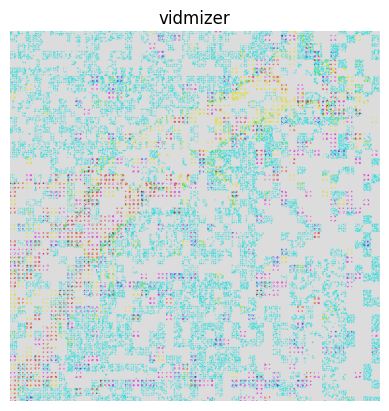

In [13]:
###### Fonction d'affichage ######
def denormalize(img_tensor):
        inverse_normalize = transforms.Normalize(
            mean=[-mean/std, -mean/std, -mean/std],
            std=[1/std, 1/std, 1/std]
        )
        return (inverse_normalize(img_tensor) * 255.).type(torch.uint8).permute(1, 2, 0).numpy()

labels_map = {
    0: "vidmizer" ,
    1: "autre",
}

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]
print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show


## Classifier

### Define the Convolutional Neural Network ( Utilisation de ResNet )

In [14]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm



In [15]:
net = torchvision.models.resnet18(weights=None)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
net.fc = nn.Linear(num_ftrs, 2)

In [16]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define a Loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)

In [18]:
num_class = 2

def quality_measurement(confusion_matrix):
    line_sum=torch.sum(confusion_matrix,dim=1)
    column_sum = torch.sum(confusion_matrix, dim=0)
    total_sum=torch.sum(confusion_matrix)
    Accuracy=torch.sum(torch.diag(confusion_matrix))/total_sum
    Precision=torch.diag(confusion_matrix)/line_sum
    Recall=torch.diag(confusion_matrix)/column_sum
    F1_score = 2 * (Precision * Recall)/(Precision+Recall)
    Pfa=(line_sum - torch.diag(confusion_matrix))/total_sum
    Pmd=(column_sum - torch.diag(confusion_matrix))/total_sum
    print("Accuracy : {}".format(Accuracy.item()))
    print("Precision 0 : {} - Precision 1 : {}".format(Precision[0],Precision[1]))
    print("Recall 0 : {} - Recall 1 : {}".format(Recall[0], Recall[1]))
    print("F1 score 0 : {} - F1 score 1 : {}".format(F1_score[0], F1_score[1]))
    print("Pfa 0 : {} - Pfa 1 : {}".format(Pfa[0], Pfa[1]))
    print("Pmd 0 : {} - Pmd 1 : {}".format(Pmd[0], Pmd[1]))
    return torch.nanmean(Accuracy),torch.nanmean(Precision),torch.nanmean(Recall),torch.nanmean(Recall),torch.nanmean(Pfa),torch.nanmean(Pmd)

def test_accuracy():
  net.eval()
  correct = 0
  total = 0
  confusion_matrix=torch.zeros((num_class,num_class),device=device)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_loader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          for i in range(len(labels)):
                label=int(labels[i])
                confusion_matrix[predicted[i],label]=confusion_matrix[predicted[i],label]+1
  net.train()
  print(quality_measurement(confusion_matrix))
  return  correct / total, confusion_matrix

In [19]:
list_lr = [0.1]#, 0.01, 0.001, 0.0001]
loss_saveds=[]
accuracy_saveds=[]
test_accuracy_saveds=[]



for lr_v in list_lr :
  net = torchvision.models.resnet18(weights=None)
  num_ftrs = net.fc.in_features
  net.fc = nn.Linear(num_ftrs, 2)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr_v)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=.1)
  net = net.to(device)
  loss_saved=[]
  accuracy_saved=[]
  test_accuracy_saved=[]


  for epoch in tqdm(range(23)):  # loop over the dataset multiple times

      running_loss = 0.0
      correct = 0
      total = 0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


      loss_saved.append(running_loss/((i+1)*batch_size))
      accuracy_saved.append(correct / total)
      running_loss = 0.0
      scheduler.step()

      test_accuracy_val, matrice_confusion = test_accuracy()
      test_accuracy_saved.append(test_accuracy_val)

  print('Finished Training')
  print('Loss : ' , loss_saved)
  print('Accuracy : ' , accuracy_saved)
  print('Accuracy : ' , test_accuracy_saved)
  print( 'Matrice de confusion : ' , matrice_confusion)
  loss_saveds.append(loss_saved)
  accuracy_saveds.append(accuracy_saved)
  test_accuracy_saveds.append(test_accuracy_saved)
  PATH = f'/content/drive/MyDrive/TSP/HTI/PFE/pfe_papier_{lr_v}_youtube.pth'
  torch.save(net.state_dict(), PATH)



  0%|          | 0/23 [00:00<?, ?it/s]

Accuracy : 0.6926470398902893
Precision 0 : 0.619307816028595 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.385294109582901
F1 score 0 : 0.7649043798446655 - F1 score 1 : 0.556263267993927
Pfa 0 : 0.3073529303073883 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.3073529303073883


  4%|▍         | 1/23 [01:47<39:34, 107.93s/it]

(tensor(0.6926, device='cuda:0'), tensor(0.8097, device='cuda:0'), tensor(0.6926, device='cuda:0'), tensor(0.6926, device='cuda:0'), tensor(0.1537, device='cuda:0'), tensor(0.1537, device='cuda:0'))


  9%|▊         | 2/23 [03:38<38:18, 109.44s/it]

Accuracy : 0.9176470637321472
Precision 0 : 0.8585858345031738 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.8352941274642944
F1 score 0 : 0.9239130020141602 - F1 score 1 : 0.9102564454078674
Pfa 0 : 0.08235294371843338 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.08235294371843338
(tensor(0.9176, device='cuda:0'), tensor(0.9293, device='cuda:0'), tensor(0.9176, device='cuda:0'), tensor(0.9176, device='cuda:0'), tensor(0.0412, device='cuda:0'), tensor(0.0412, device='cuda:0'))


 13%|█▎        | 3/23 [05:32<37:15, 111.76s/it]

Accuracy : 0.9352940917015076
Precision 0 : 0.8854166865348816 - Precision 1 : 1.0
Recall 0 : 1.0 - Recall 1 : 0.8705882430076599
F1 score 0 : 0.939226508140564 - F1 score 1 : 0.9308176040649414
Pfa 0 : 0.06470588594675064 - Pfa 1 : 0.0
Pmd 0 : 0.0 - Pmd 1 : 0.06470588594675064
(tensor(0.9353, device='cuda:0'), tensor(0.9427, device='cuda:0'), tensor(0.9353, device='cuda:0'), tensor(0.9353, device='cuda:0'), tensor(0.0324, device='cuda:0'), tensor(0.0324, device='cuda:0'))


 17%|█▋        | 4/23 [07:28<35:55, 113.43s/it]

Accuracy : 0.9411764740943909
Precision 0 : 0.9411764740943909 - Precision 1 : 0.9411764740943909
Recall 0 : 0.9411764740943909 - Recall 1 : 0.9411764740943909
F1 score 0 : 0.9411764740943909 - F1 score 1 : 0.9411764740943909
Pfa 0 : 0.029411764815449715 - Pfa 1 : 0.029411764815449715
Pmd 0 : 0.029411764815449715 - Pmd 1 : 0.029411764815449715
(tensor(0.9412, device='cuda:0'), tensor(0.9412, device='cuda:0'), tensor(0.9412, device='cuda:0'), tensor(0.9412, device='cuda:0'), tensor(0.0294, device='cuda:0'), tensor(0.0294, device='cuda:0'))


 22%|██▏       | 5/23 [09:24<34:17, 114.30s/it]

Accuracy : 0.9441176652908325
Precision 0 : 0.9934640526771545 - Precision 1 : 0.903743326663971
Recall 0 : 0.8941176533699036 - Recall 1 : 0.9941176176071167
F1 score 0 : 0.9411765336990356 - F1 score 1 : 0.9467787146568298
Pfa 0 : 0.0029411765281111 - Pfa 1 : 0.052941177040338516
Pmd 0 : 0.052941177040338516 - Pmd 1 : 0.0029411765281111
(tensor(0.9441, device='cuda:0'), tensor(0.9486, device='cuda:0'), tensor(0.9441, device='cuda:0'), tensor(0.9441, device='cuda:0'), tensor(0.0279, device='cuda:0'), tensor(0.0279, device='cuda:0'))


 26%|██▌       | 6/23 [11:20<32:34, 114.94s/it]

Accuracy : 0.9691176414489746
Precision 0 : 0.9570200443267822 - Precision 1 : 0.981873095035553
Recall 0 : 0.9823529124259949 - Recall 1 : 0.9558823704719543
F1 score 0 : 0.9695209860801697 - F1 score 1 : 0.9687034487724304
Pfa 0 : 0.022058824077248573 - Pfa 1 : 0.008823529817163944
Pmd 0 : 0.008823529817163944 - Pmd 1 : 0.022058824077248573
(tensor(0.9691, device='cuda:0'), tensor(0.9694, device='cuda:0'), tensor(0.9691, device='cuda:0'), tensor(0.9691, device='cuda:0'), tensor(0.0154, device='cuda:0'), tensor(0.0154, device='cuda:0'))


 30%|███       | 7/23 [13:19<30:58, 116.15s/it]

Accuracy : 0.9764705896377563
Precision 0 : 0.9682080745697021 - Precision 1 : 0.985029935836792
Recall 0 : 0.9852941036224365 - Recall 1 : 0.9676470756530762
F1 score 0 : 0.9766764044761658 - F1 score 1 : 0.9762611389160156
Pfa 0 : 0.01617647148668766 - Pfa 1 : 0.007352941203862429
Pmd 0 : 0.007352941203862429 - Pmd 1 : 0.01617647148668766
(tensor(0.9765, device='cuda:0'), tensor(0.9766, device='cuda:0'), tensor(0.9765, device='cuda:0'), tensor(0.9765, device='cuda:0'), tensor(0.0118, device='cuda:0'), tensor(0.0118, device='cuda:0'))


 35%|███▍      | 8/23 [15:18<29:17, 117.17s/it]

Accuracy : 0.9617646932601929
Precision 0 : 0.9460227489471436 - Precision 1 : 0.9786585569381714
Recall 0 : 0.979411780834198 - Recall 1 : 0.9441176652908325
F1 score 0 : 0.9624277353286743 - F1 score 1 : 0.961077868938446
Pfa 0 : 0.027941176667809486 - Pfa 1 : 0.010294117964804173
Pmd 0 : 0.010294117964804173 - Pmd 1 : 0.027941176667809486
(tensor(0.9618, device='cuda:0'), tensor(0.9623, device='cuda:0'), tensor(0.9618, device='cuda:0'), tensor(0.9618, device='cuda:0'), tensor(0.0191, device='cuda:0'), tensor(0.0191, device='cuda:0'))


 39%|███▉      | 9/23 [17:19<27:33, 118.09s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9684813618659973 - Precision 1 : 0.9939576983451843
Recall 0 : 0.9941176176071167 - Recall 1 : 0.9676470756530762
F1 score 0 : 0.9811320304870605 - F1 score 1 : 0.9806259274482727
Pfa 0 : 0.01617647148668766 - Pfa 1 : 0.0029411765281111
Pmd 0 : 0.0029411765281111 - Pmd 1 : 0.01617647148668766
(tensor(0.9809, device='cuda:0'), tensor(0.9812, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 43%|████▎     | 10/23 [19:20<25:48, 119.11s/it]

Accuracy : 0.9735293984413147
Precision 0 : 0.9522472023963928 - Precision 1 : 0.9969135522842407
Recall 0 : 0.9970588088035583 - Recall 1 : 0.949999988079071
F1 score 0 : 0.9741379022598267 - F1 score 1 : 0.9728915691375732
Pfa 0 : 0.02500000037252903 - Pfa 1 : 0.00147058826405555
Pmd 0 : 0.00147058826405555 - Pmd 1 : 0.02500000037252903
(tensor(0.9735, device='cuda:0'), tensor(0.9746, device='cuda:0'), tensor(0.9735, device='cuda:0'), tensor(0.9735, device='cuda:0'), tensor(0.0132, device='cuda:0'), tensor(0.0132, device='cuda:0'))


 48%|████▊     | 11/23 [21:23<24:03, 120.29s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9711815714836121 - Precision 1 : 0.9909909963607788
Recall 0 : 0.9911764860153198 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9810771942138672 - F1 score 1 : 0.980683445930481
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.014705882407724857
(tensor(0.9809, device='cuda:0'), tensor(0.9811, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 52%|█████▏    | 12/23 [23:26<22:11, 121.06s/it]

Accuracy : 0.9823529124259949
Precision 0 : 0.97398841381073 - Precision 1 : 0.9910179376602173
Recall 0 : 0.9911764860153198 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9825072884559631 - F1 score 1 : 0.9821957945823669
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.013235294260084629
(tensor(0.9824, device='cuda:0'), tensor(0.9825, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0088, device='cuda:0'))


 57%|█████▋    | 13/23 [25:27<20:10, 121.01s/it]

Accuracy : 0.9838235378265381
Precision 0 : 0.9713466763496399 - Precision 1 : 0.9969788789749146
Recall 0 : 0.9970588088035583 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9840348362922668 - F1 score 1 : 0.9836065769195557
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.00147058826405555
Pmd 0 : 0.00147058826405555 - Pmd 1 : 0.014705882407724857
(tensor(0.9838, device='cuda:0'), tensor(0.9842, device='cuda:0'), tensor(0.9838, device='cuda:0'), tensor(0.9838, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0081, device='cuda:0'))


 61%|██████    | 14/23 [27:30<18:14, 121.58s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9739130139350891 - Precision 1 : 0.9880596995353699
Recall 0 : 0.9882352948188782 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9810218811035156 - F1 score 1 : 0.9807407259941101
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.0058823530562222
Pmd 0 : 0.0058823530562222 - Pmd 1 : 0.013235294260084629
(tensor(0.9809, device='cuda:0'), tensor(0.9810, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 65%|██████▌   | 15/23 [29:30<16:09, 121.21s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9739130139350891 - Precision 1 : 0.9880596995353699
Recall 0 : 0.9882352948188782 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9810218811035156 - F1 score 1 : 0.9807407259941101
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.0058823530562222
Pmd 0 : 0.0058823530562222 - Pmd 1 : 0.013235294260084629
(tensor(0.9809, device='cuda:0'), tensor(0.9810, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 70%|██████▉   | 16/23 [31:31<14:08, 121.23s/it]

Accuracy : 0.9823529124259949
Precision 0 : 0.97398841381073 - Precision 1 : 0.9910179376602173
Recall 0 : 0.9911764860153198 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9825072884559631 - F1 score 1 : 0.9821957945823669
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.013235294260084629
(tensor(0.9824, device='cuda:0'), tensor(0.9825, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0088, device='cuda:0'))


 74%|███████▍  | 17/23 [33:34<12:09, 121.64s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9711815714836121 - Precision 1 : 0.9909909963607788
Recall 0 : 0.9911764860153198 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9810771942138672 - F1 score 1 : 0.980683445930481
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.014705882407724857
(tensor(0.9809, device='cuda:0'), tensor(0.9811, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 78%|███████▊  | 18/23 [35:36<10:09, 121.85s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9711815714836121 - Precision 1 : 0.9909909963607788
Recall 0 : 0.9911764860153198 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9810771942138672 - F1 score 1 : 0.980683445930481
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.014705882407724857
(tensor(0.9809, device='cuda:0'), tensor(0.9811, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 83%|████████▎ | 19/23 [37:38<08:08, 122.00s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9739130139350891 - Precision 1 : 0.9880596995353699
Recall 0 : 0.9882352948188782 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9810218811035156 - F1 score 1 : 0.9807407259941101
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.0058823530562222
Pmd 0 : 0.0058823530562222 - Pmd 1 : 0.013235294260084629
(tensor(0.9809, device='cuda:0'), tensor(0.9810, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))


 87%|████████▋ | 20/23 [39:40<06:05, 121.76s/it]

Accuracy : 0.9823529124259949
Precision 0 : 0.97398841381073 - Precision 1 : 0.9910179376602173
Recall 0 : 0.9911764860153198 - Recall 1 : 0.9735293984413147
F1 score 0 : 0.9825072884559631 - F1 score 1 : 0.9821957945823669
Pfa 0 : 0.013235294260084629 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.013235294260084629
(tensor(0.9824, device='cuda:0'), tensor(0.9825, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0088, device='cuda:0'))


 91%|█████████▏| 21/23 [41:42<04:03, 121.85s/it]

Accuracy : 0.9823529124259949
Precision 0 : 0.9712643623352051 - Precision 1 : 0.9939758777618408
Recall 0 : 0.9941176176071167 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9825581312179565 - F1 score 1 : 0.9821428656578064
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.0029411765281111
Pmd 0 : 0.0029411765281111 - Pmd 1 : 0.014705882407724857
(tensor(0.9824, device='cuda:0'), tensor(0.9826, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.9824, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0088, device='cuda:0'))


 96%|█████████▌| 22/23 [43:47<02:02, 122.76s/it]

Accuracy : 0.9838235378265381
Precision 0 : 0.9713466763496399 - Precision 1 : 0.9969788789749146
Recall 0 : 0.9970588088035583 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9840348362922668 - F1 score 1 : 0.9836065769195557
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.00147058826405555
Pmd 0 : 0.00147058826405555 - Pmd 1 : 0.014705882407724857
(tensor(0.9838, device='cuda:0'), tensor(0.9842, device='cuda:0'), tensor(0.9838, device='cuda:0'), tensor(0.9838, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0081, device='cuda:0'))


100%|██████████| 23/23 [45:47<00:00, 119.46s/it]

Accuracy : 0.9808823466300964
Precision 0 : 0.9711815714836121 - Precision 1 : 0.9909909963607788
Recall 0 : 0.9911764860153198 - Recall 1 : 0.970588207244873
F1 score 0 : 0.9810771942138672 - F1 score 1 : 0.980683445930481
Pfa 0 : 0.014705882407724857 - Pfa 1 : 0.004411764908581972
Pmd 0 : 0.004411764908581972 - Pmd 1 : 0.014705882407724857
(tensor(0.9809, device='cuda:0'), tensor(0.9811, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.9809, device='cuda:0'), tensor(0.0096, device='cuda:0'), tensor(0.0096, device='cuda:0'))
Finished Training
Loss :  [0.011842743610031903, 0.004956806998961838, 0.0026410516766190995, 0.0025949873415811453, 0.002490564151230501, 0.001475240907893749, 0.001078786472135107, 0.0010170625619139173, 0.0011432163855715771, 0.0004678734140952656, 0.00037351552117570463, 0.0003404672892770577, 0.00036043739794422436, 0.0002957913137606738, 0.0003194525253888969, 0.0002826993192002192, 0.0002718787303308545, 0.00026248156558494884, 0.0002801718050591

### Print de la loss en fonction des epochs

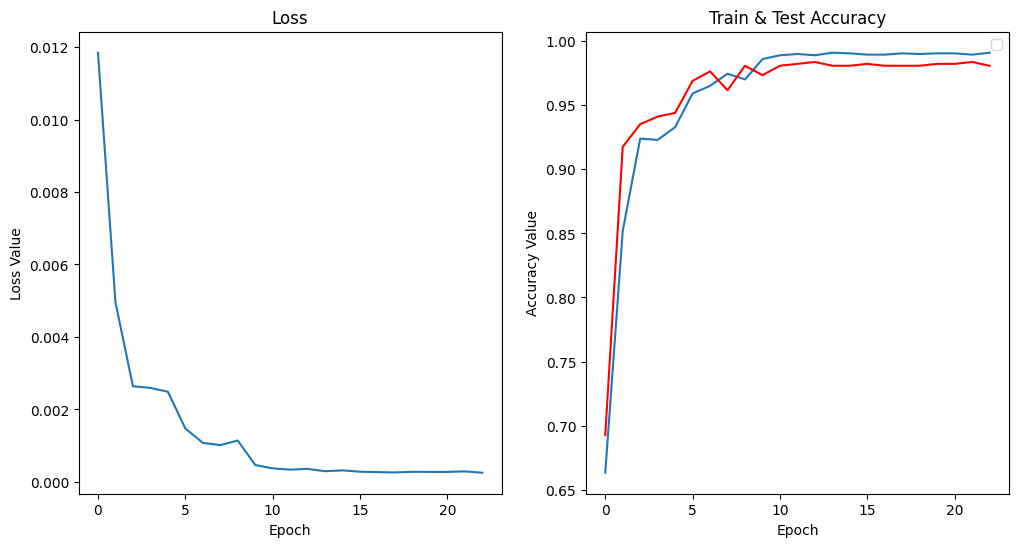

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_saved)
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.title('Train & Test Accuracy')
plt.plot(accuracy_saved)
plt.plot(test_accuracy_saved, color='r')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend()

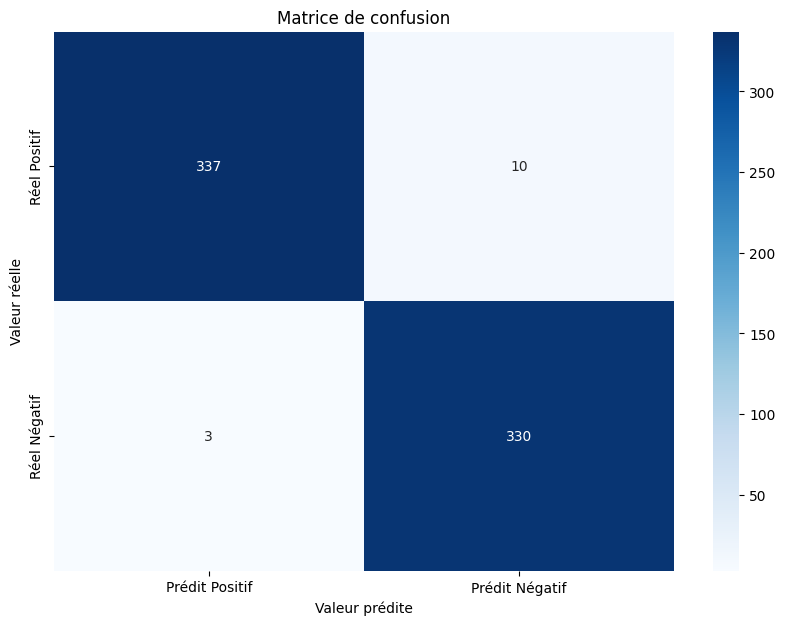

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Données de la matrice de confusion
conf_matrix = [[337, 10], [3, 330]]

# Conversion en DataFrame pour une meilleure visualisation avec Seaborn
df_cm = pd.DataFrame(conf_matrix, index=["Réel Positif", "Réel Négatif"], columns=["Prédit Positif", "Prédit Négatif"])

# Tracé de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()


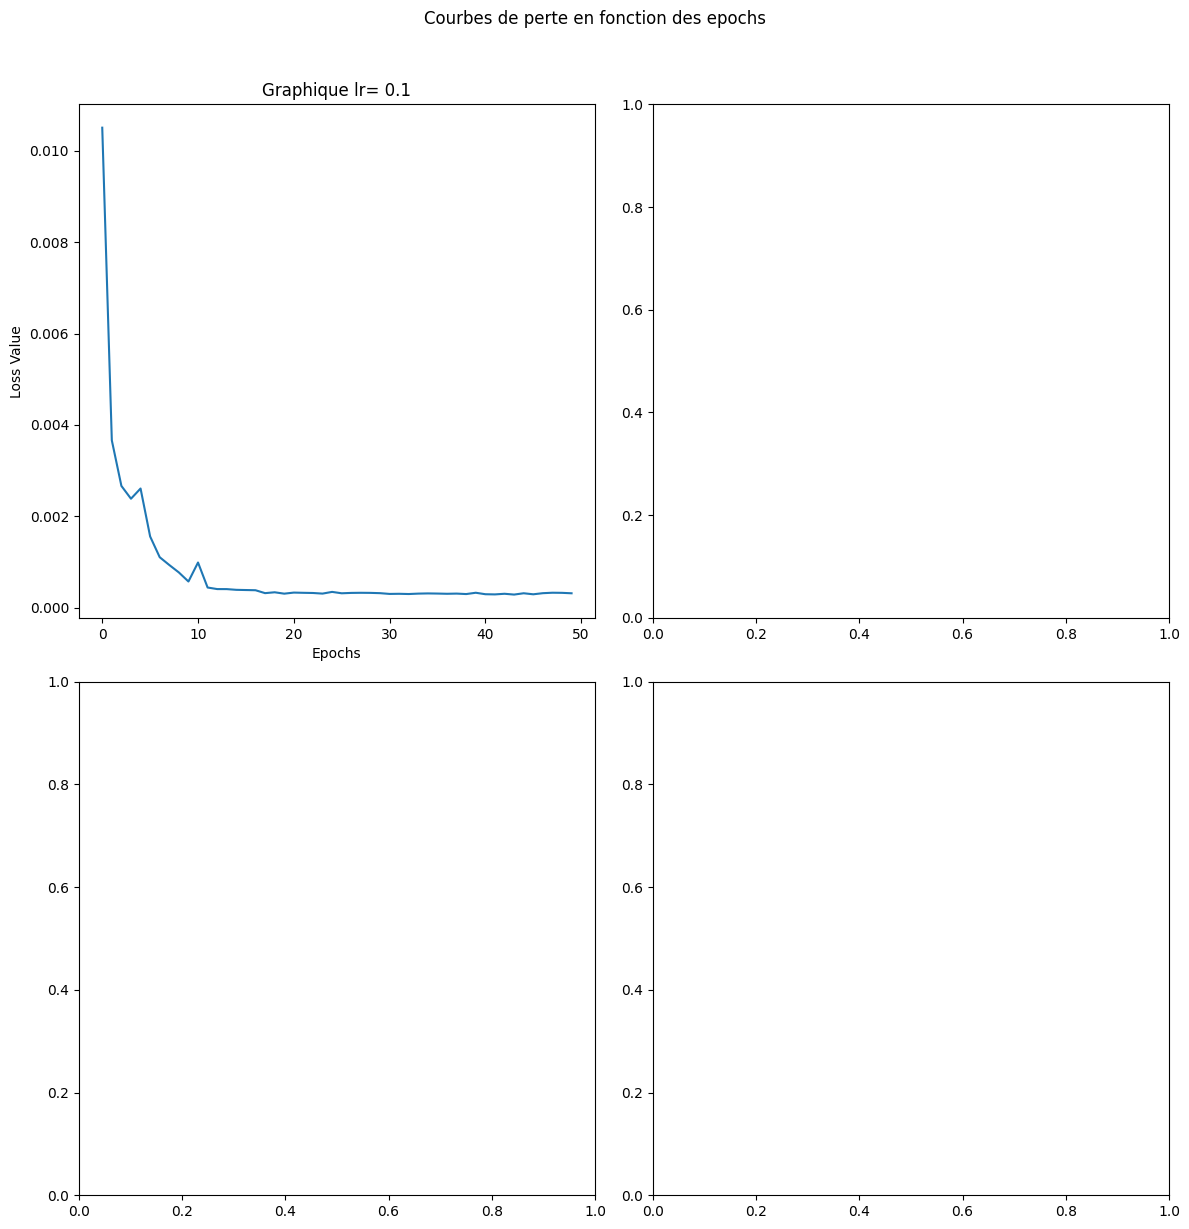

In [ ]:
import matplotlib.pyplot as plt

# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes de perte en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, loss_saved in enumerate(loss_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(loss_saved)


    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Print de l'accuracy en fonction des epochs

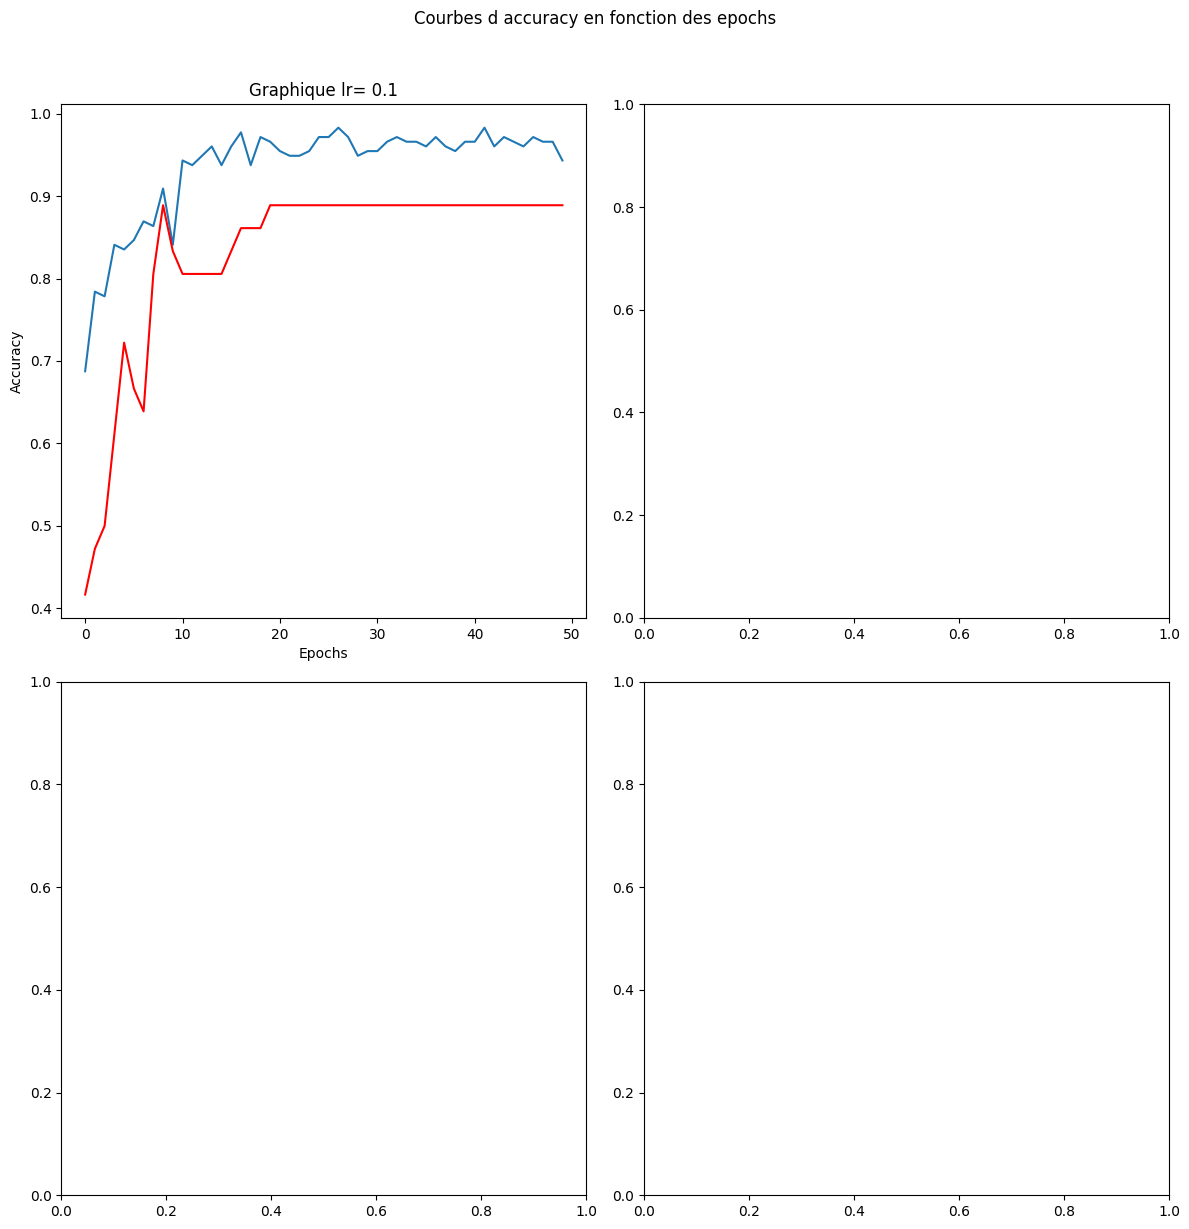

In [ ]:
# Création d'une grille pour afficher les graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 6 * 2))
fig.suptitle('Courbes d accuracy en fonction des epochs', y=1.02)  # Titre global

# Affichage des courbes dans la grille
for i, accuracy_saved in enumerate(accuracy_saveds):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(accuracy_saved,label='train')
    ax.plot(test_accuracy_saveds[i],color='r',label='test')

    # Ajout de titres aux axes pour chaque sous-plot
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Graphique lr= {list_lr[i]}')

# Ajustement de l'espacement entre les sous-plots
plt.tight_layout()

# Affichage de la grille
plt.show()

### Test the network on the test data

#### First test on one frame

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

img = images[0].cpu()  # Copie le tensor sur le CPU
label = labels[0].cpu()  # Copie le tensor sur le CPU

print(img.size())

plt.title(labels_map[int(label.numpy())])
plt.axis("off")
plt.imshow(denormalize(img))
plt.show

torch.Size([3, 576, 576])


NameError: name 'labels_map' is not defined

In [ ]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

In [ ]:
predicted = predicted.cpu()  # Copie le tensor sur le CPU
print(labels_map[int(predicted[0].numpy())])


NameError: name 'labels_map' is not defined

#### Let us look at how the network performs on the whole dataset

#### Result by class

In [ ]:
classes = ('vidmizer','autre')
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)  # Copie les images sur le GPU
        labels = labels.to(device)  # Copie les étiquettes sur le GPU
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: vidmizer is 34.2 %
Accuracy for class: autre is 68.2 %
